<p style="font-size:36px;text-align:center"> <b>Customer relationship prediction</b> </p>

<h1>1. Business Problem</h1>

<p> Source: https://www.kdd.org/kdd-cup/view/kdd-cup-2009/Intro/ </p>

<h6> Context:</h6>
<p> Source: https://www.kdd.org/kdd-cup/view/kdd-cup-2009/Tasks</p>

<h6> Problem statement : </h6>
<p> The task is to estimate the churn, appetency and up-selling probability of customers, hence there are three target values to be predicted.  </p>
<p> The  data provided is  masked customer records and their goal was to predict whether a customer will switch provider (churn),</p>
 <p> buy the main service (appetency) and/or buy additional extras (up-selling), hence solving three binary classification problems.</p>

<h2>1.2. Source/Useful Links</h2>

 Some articles and reference blogs about the problem statement
 
 http://proceedings.mlr.press/v7/guyon09/guyon09.pdf

<h2>1.3. Real-world/Business objectives and constraints.</h2>

<p> The requirements placed  are to obtain a high classification accuracy, under the following constraints: </p>

* Maximizing accuracy undertime constraints

* Interpretability is important.

* Probability of a data-point belonging to each class is needed.

<p> Besides, the above the challenge was to beat the in-house AUC score of 0.8311 with the following results on the test dataset: </p>

* Churn problem : AUC = 0.7435;

* Appetency problem : AUC = 0.8522;

* Up-selling problem : AUC=0.8975;


<h1>2. Machine Learning Problem Formulation</h1>

<h3>2.1.1. Data Overview</h3>

Orange (the French Telecom company) made available a large dataset of customer data, each consisting of:

3

• Training : 50,000 instances including 230 inputs variables, and the target value.

• Test : 50,000 instances including 230 inputs variables.

In [ ]:
The data are 

<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<h3>2.2.1. Type of Machine Learning Problem</h3>

<p>There are 2 differerent classes for each item to be predicted, so its a binary classification.</p>

<h3>2.2.2. Performance Metric</h3>

Source: http://proceedings.mlr.press/v7/guyon09/guyon09.pdf#evaluation

Metric(s):

* Auc 
* Confusion matrix 

<h3>2.2.3. Machine Learing Objectives and Constraints</h3>

<p> Objective: Predict the probability of each data-point belonging to each of the 2 classes.
</p>
<p> Constraints:
</p>
* Interpretability
* Class probabilities are needed.
* Auc Score.
*  Latency constraints.

<h2>2.3. Train, CV and Test Datasets</h2>

 Split the dataset randomly into two parts train, and test with 80%, 20% of data respectively

In [57]:
#Loading libararies
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
import pandas_profiling
from fancyimpute import KNN,SoftImpute
from sklearn.utils import resample
import warnings
import missingno as no
warnings.filterwarnings("ignore")
%matplotlib inline

##### Helper Functions 

In [2]:
def _getOneHotCode(df):
    for cat_feature in df.select_dtypes(include=['object']).columns:
        df[cat_feature] = pd.Categorical(df[cat_feature]).codes
        df[cat_feature] = df[cat_feature].replace(-1,np.nan)
    return pd.DataFrame(df)

def fnc_Imputer(df):
    imp_cols = df.columns.values
    imputer = SoftImpute()
    return pd.DataFrame(imputer.fit_transform(df), columns= imp_cols)

def _missingValueImputer(df):
    imp_cols = df.columns.values
    imputer = KNN(k=5)
    return pd.DataFrame(imputer.complete(df), columns= imp_cols)

#https://ajh1143.github.io/Corr/
def halfHeatMap(df, mirror):
       # Create Correlation df
       corr = df.corr()
       # Plot figsize
       fig, ax = plt.subplots(figsize=(11, 9))
       # Generate Color Map
       colormap = sns.diverging_palette(10, 220, as_cmap=True)

       if mirror == True:
          #Generate Heat Map, allow annotations and place floats in map
          sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
          #Apply xticks
          plt.xticks(range(len(corr.columns)), corr.columns);
          #Apply yticks
          plt.yticks(range(len(corr.columns)), corr.columns)
          #show plot

       else:
          # Drop self-correlations
          dropSelf = np.zeros_like(corr)
          dropSelf[np.triu_indices_from(dropSelf)] = True
          # Generate Color Map
          cmap = sns.diverging_palette(10, 220, as_cmap=True)
          # Generate Heat Map, allow annotations and place floats in map
          sns.heatmap(corr, mask=dropSelf, cmap=cmap, vmax=.3, center=0,annot=False, annot_kws={"size": 8}, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

       # show plot
       plt.show()


<h1>3. Loading the Dataset</h1>

In [3]:
#Loading datasets
#train and test files
df_train = pd.read_csv(zipfile.ZipFile('orange_small_train.data.zip').open('orange_small_train.data'),sep='\t')
df_test = pd.read_csv(zipfile.ZipFile('orange_small_test.data.zip').open('orange_small_test.data'),sep='\t')

In [4]:
print("Number of rows in the train dataset ",df_train.shape[0])
print("Number of columns in the train dataset ",df_train.shape[1])

Number of rows in the train dataset  50000
Number of columns in the train dataset  230


In [5]:
print("Number of rows in the test dataset ",df_test.shape[0])
print("Number of columns in the test dataset ",df_test.shape[1])

Number of rows in the test dataset  50000
Number of columns in the test dataset  230


<h3>3.1. Data profiling</h3>

<p><b>Profiling</b> is a process that helps us in understanding our data and Pandas Profiling is python package which does exactly that. </p>
<p>It is a simple and fast way to perform exploratory data analysis of a Pandas Dataframe. </p>
<p>The pandas df.describe()and df.info()functions are normally used as a first step in the EDA process. </p>
<p>However, it only gives a very basic overview of the data and doesn’t help much in the case of large data sets.</p>
<p>The Pandas Profiling function, on the other hand, displays a lot of information with a single line of code and that too in an interactive HTML report.</p>

In [6]:
pandas_profiling.ProfileReport(df_train)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 230 entries, Var1 to Var230
dtypes: float64(191), int64(1), object(38)
memory usage: 87.7+ MB


##### There are 230 columns, of which 192 are float and remaining 38 are floats

In [8]:
df_train.isnull().sum()

Var1      49298
Var2      48759
Var3      48760
Var4      48421
Var5      48513
Var6       5529
Var7       5539
Var8      50000
Var9      49298
Var10     48513
Var11     48760
Var12     49442
Var13      5539
Var14     48760
Var15     50000
Var16     48513
Var17     48421
Var18     48421
Var19     48421
Var20     50000
Var21      5529
Var22      5009
Var23     48513
Var24      7230
Var25      5009
Var26     48513
Var27     48513
Var28      5011
Var29     49298
Var30     49298
          ...  
Var201    37217
Var202        1
Var203      143
Var204        0
Var205     1934
Var206     5529
Var207        0
Var208      143
Var209    50000
Var210        0
Var211        0
Var212        0
Var213    48871
Var214    25408
Var215    49306
Var216        0
Var217      703
Var218      703
Var219     5211
Var220        0
Var221        0
Var222        0
Var223     5211
Var224    49180
Var225    26144
Var226        0
Var227        0
Var228        0
Var229    28432
Var230    50000
Length: 230, dtype: int6

,Total,Percent
Var230,50000,1.00000
Var39,50000,1.00000
Var185,50000,1.00000
Var79,50000,1.00000
Var169,50000,1.00000
Var55,50000,1.00000
Var141,50000,1.00000
Var52,50000,1.00000
Var48,50000,1.00000
Var42,50000,1.00000


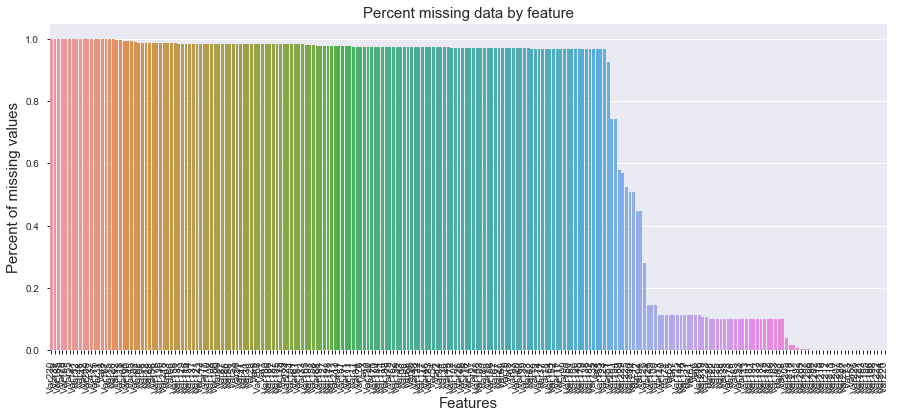

In [9]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head(100)

<i><b>The basic underatanding is that alot of cells are empty . As given by data profiling tool, it says 69% of data is empty. 
Hence, we cannot drop all the cells that are empty. 
    We will drop those cells that have 75% Nan and rest impute them.</b></i>

In [10]:
#Adding labels to train_df
df_train['appetency'] = pd.read_csv('orange_small_train_appetency.labels',header = None)
df_train['churn'] = pd.read_csv('orange_small_train_churn.labels',header = None)
df_train['upselling'] = pd.read_csv('orange_small_train_upselling.labels',header = None)

In [11]:
print("After concating appetency,churn and upselling",df_train.shape)

After concating appetency,churn and upselling (50000, 233)


In [12]:
print ('Printing top 3 rows',df_train.head(3))

Printing top 3 rows    Var1  Var2  Var3  Var4  Var5    Var6  Var7  Var8  Var9  Var10  ...  Var224  \
0   NaN   NaN   NaN   NaN   NaN  1526.0   7.0   NaN   NaN    NaN  ...     NaN   
1   NaN   NaN   NaN   NaN   NaN   525.0   0.0   NaN   NaN    NaN  ...     NaN   
2   NaN   NaN   NaN   NaN   NaN  5236.0   7.0   NaN   NaN    NaN  ...     NaN   

   Var225  Var226   Var227         Var228  Var229  Var230  appetency  churn  \
0     NaN    xb3V     RAYp  F2FyR07IdsN7I     NaN     NaN         -1     -1   
1     NaN    fKCe     RAYp  F2FyR07IdsN7I     NaN     NaN         -1      1   
2    kG3k    Qu4f  02N6s8f  ib5G6X1eUxUn6    am7c     NaN         -1     -1   

   upselling  
0         -1  
1         -1  
2         -1  

[3 rows x 233 columns]


<h3>3.2.Data Preparation</h1>

<i><b> As lot of cells are empty,so we will keep only the columns where more than 25% are not empty. </b></i>

In [13]:
df_sampled =df_train.copy()
df_new = df_sampled[[i for i in df_sampled if df_sampled[i].count() / len(df_sampled) >= 0.25]]
print("The coulmns that are excluded are:", end=" ")
for c in df_sampled.columns:
    if c not in df_new.columns:
        print(c, end=", ")

The coulmns that are excluded are: Var1, Var2, Var3, Var4, Var5, Var8, Var9, Var10, Var11, Var12, Var14, Var15, Var16, Var17, Var18, Var19, Var20, Var23, Var26, Var27, Var29, Var30, Var31, Var32, Var33, Var34, Var36, Var37, Var39, Var40, Var41, Var42, Var43, Var45, Var46, Var47, Var48, Var49, Var50, Var51, Var52, Var53, Var54, Var55, Var56, Var58, Var59, Var60, Var61, Var62, Var63, Var64, Var66, Var67, Var68, Var69, Var70, Var71, Var75, Var77, Var79, Var80, Var82, Var84, Var86, Var87, Var88, Var89, Var90, Var91, Var92, Var93, Var95, Var96, Var97, Var98, Var99, Var100, Var101, Var102, Var103, Var104, Var105, Var106, Var107, Var108, Var110, Var111, Var114, Var115, Var116, Var117, Var118, Var120, Var121, Var122, Var124, Var127, Var128, Var129, Var130, Var131, Var135, Var136, Var137, Var138, Var139, Var141, Var142, Var145, Var146, Var147, Var148, Var150, Var151, Var152, Var154, Var155, Var156, Var157, Var158, Var159, Var161, Var162, Var164, Var165, Var166, Var167, Var168, Var169, Var170, V

In [14]:
df_new.shape

(50000, 79)

<i><b> Now, we have only 79 columns to deal with, as the reamining with more than 75% empty cells are dropped </b></i>

In [15]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 79 columns):
Var6         44471 non-null float64
Var7         44461 non-null float64
Var13        44461 non-null float64
Var21        44471 non-null float64
Var22        44991 non-null float64
Var24        42770 non-null float64
Var25        44991 non-null float64
Var28        44989 non-null float64
Var35        44991 non-null float64
Var38        44991 non-null float64
Var44        44991 non-null float64
Var57        50000 non-null float64
Var65        44461 non-null float64
Var72        27620 non-null float64
Var73        50000 non-null int64
Var74        44461 non-null float64
Var76        44991 non-null float64
Var78        44991 non-null float64
Var81        44471 non-null float64
Var83        44991 non-null float64
Var85        44991 non-null float64
Var94        27620 non-null float64
Var109       42770 non-null float64
Var112       44991 non-null float64
Var113       50000 non-null f

### The datatypes are float,int and objects. 

,Total,Percent
Var201,37217,0.74434
Var194,37216,0.74432
Var189,28978,0.57956
Var229,28432,0.56864
Var225,26144,0.52288
Var214,25408,0.50816
Var200,25408,0.50816
Var94,22380,0.44760
Var72,22380,0.44760
Var126,13920,0.27840


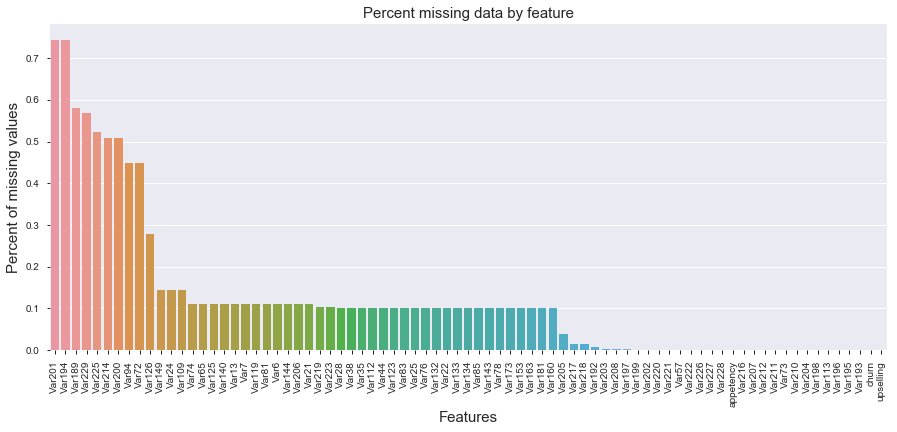

In [17]:
total = df_new.isnull().sum().sort_values(ascending=False)
percent = (df_new.isnull().sum()/df_new.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head(100)

### Convert the Categorical Variables Into Dummy Variables

<b>One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.</b>

In [19]:
df_new.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var222,Var223,Var225,Var226,Var227,Var228,Var229,appetency,churn,upselling
0,1526.0,7.0,184.0,464.0,580.0,14.0,128.0,166.56,0.0,3570.0,...,fXVEsaq,jySVZNlOJy,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,-1,-1,-1
1,525.0,0.0,0.0,168.0,210.0,2.0,24.0,353.52,0.0,4764966.0,...,2Kb5FSF,LM8l689qOp,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,-1,1,-1
2,5236.0,7.0,904.0,1212.0,1515.0,26.0,816.0,220.08,0.0,5883894.0,...,NKv4yOc,jySVZNlOJy,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,-1,-1,-1
3,NaN,0.0,0.0,NaN,0.0,NaN,0.0,22.08,0.0,0.0,...,CE7uk3u,LM8l689qOp,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,-1,-1,-1
4,1029.0,7.0,3216.0,64.0,80.0,4.0,64.0,200.00,0.0,0.0,...,1J2cvxe,LM8l689qOp,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,-1,-1,-1


In [20]:
df_new1 = df_new
df_new1 = _getOneHotCode(df_new)
df_new1.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var222,Var223,Var225,Var226,Var227,Var228,Var229,appetency,churn,upselling
0,1526.0,7.0,184.0,464.0,580.0,14.0,128.0,166.56,0.0,3570.0,...,2964,3.0,NaN,22,2,8,NaN,-1,-1,-1
1,525.0,0.0,0.0,168.0,210.0,2.0,24.0,353.52,0.0,4764966.0,...,125,0.0,NaN,14,2,8,NaN,-1,1,-1
2,5236.0,7.0,904.0,1212.0,1515.0,26.0,816.0,220.08,0.0,5883894.0,...,1610,3.0,1.0,10,0,25,0.0,-1,-1,-1
3,NaN,0.0,0.0,NaN,0.0,NaN,0.0,22.08,0.0,0.0,...,817,0.0,NaN,7,2,8,NaN,-1,-1,-1
4,1029.0,7.0,3216.0,64.0,80.0,4.0,64.0,200.00,0.0,0.0,...,65,0.0,1.0,7,2,8,1.0,-1,-1,-1


<h3>3.3. Imputation</h1>
Imputation fills in the missing value with some number. The imputed value won't be exactly right in most cases, but it usually gives more accurate models than dropping the column entirely.
http://web.stanford.edu/~hastie/Papers/mazumder10a.pdf

In [22]:
#https://pypi.org/project/fancyimpute/
df_new2 = fnc_Imputer(df_new1)

[SoftImpute] Max Singular Value of X_init = 1894271139.768993
[SoftImpute] Iter 1: observed MAE=12772.663208 rank=8
[SoftImpute] Iter 2: observed MAE=12801.810677 rank=8
[SoftImpute] Iter 3: observed MAE=12814.979283 rank=8
[SoftImpute] Iter 4: observed MAE=12819.832292 rank=8
[SoftImpute] Iter 5: observed MAE=12821.579556 rank=8
[SoftImpute] Iter 6: observed MAE=12822.248338 rank=8
[SoftImpute] Iter 7: observed MAE=12822.551492 rank=8
[SoftImpute] Iter 8: observed MAE=12822.726326 rank=8
[SoftImpute] Iter 9: observed MAE=12822.851230 rank=8
[SoftImpute] Iter 10: observed MAE=12822.953941 rank=8
[SoftImpute] Iter 11: observed MAE=12823.044706 rank=8
[SoftImpute] Iter 12: observed MAE=12823.127007 rank=8
[SoftImpute] Iter 13: observed MAE=12823.202621 rank=8
[SoftImpute] Iter 14: observed MAE=12823.272571 rank=8
[SoftImpute] Iter 15: observed MAE=12823.337683 rank=8
[SoftImpute] Iter 16: observed MAE=12823.398476 rank=8
[SoftImpute] Iter 17: observed MAE=12823.455557 rank=8
[SoftImpute]

In [30]:
print("The no of datatypes present in the dataset\n",df_new2.get_dtype_counts())

The no of datatypes present in the dataset
 float64    79
dtype: int64


#### Creating 3 different datasets ,each for Appetency,Churn and Upselling

In [31]:
df_train_churn= df_new2.drop(['appetency','upselling'],axis=1)
df_train_appetency= df_new2.drop(['churn','upselling'],axis=1)
df_train_upselling= df_new2.drop(['appetency','churn'],axis=1)

In [32]:
df_train_churn.churn.value_counts()

-1.0    46328
 1.0     3672
Name: churn, dtype: int64

In [33]:
#Changing labels to 0 or 1 from -1 and 1 resp.
df_train_churn['churn']=(df_train_churn['churn']+ 1)/2
df_train_appetency['appetency']=(df_train_appetency['appetency']+ 1)/2
df_train_upselling['upselling']=(df_train_upselling['upselling']+ 1)/2

In [34]:
#Changing the datatype of appetency,churn and upselling from float to int
df_train_appetency['appetency']=df_train_appetency['appetency'].astype('int64')
df_train_churn['churn']=df_train_churn['churn'].astype('int64')
df_train_upselling['upselling']=df_train_upselling['upselling'].astype('int64')

### Saving the dataframe to csv for further analysis based on three categories

In [35]:
df_train_churn.to_csv('df_train_churn.csv') 
df_train_upselling.to_csv('df_train_upselling.csv') 
df_train_appetency.to_csv('df_train_appetency.csv') 
df_new2.to_csv('df_new2.csv')

<h1>4. Exploratory Data Analysis</h1>

##### appetency

In [36]:
df_train_appetency['appetency'].describe()

count    50000.000000
mean         0.017800
std          0.132225
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: appetency, dtype: float64

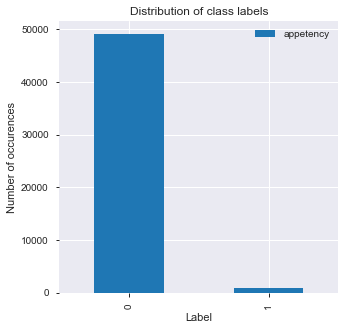

In [37]:
#Check the class distribution in the given data
df_train_appetency['appetency'].value_counts().plot(figsize=(5,5),kind='bar',legend='True')
plt.title("Distribution of class labels")
plt.xlabel("Label")
plt.ylabel("Number of occurences")
plt.show()

In [38]:
#Get percentage  information
not_appetency=df_train_appetency[df_train_appetency['appetency']==0].shape[0]
appetency=df_train_appetency[df_train_appetency['appetency']==1].shape[0]
total=not_appetency+appetency

print("Percentage of Not appetency: {}".format(np.round(100*appetency/total,4)))
print("Percentage of appetency: {}".format(np.round(100*not_appetency/total,4)))

Percentage of Not appetency: 1.78
Percentage of appetency: 98.22


#### Observation:- The dataset is clearly imbalanced.

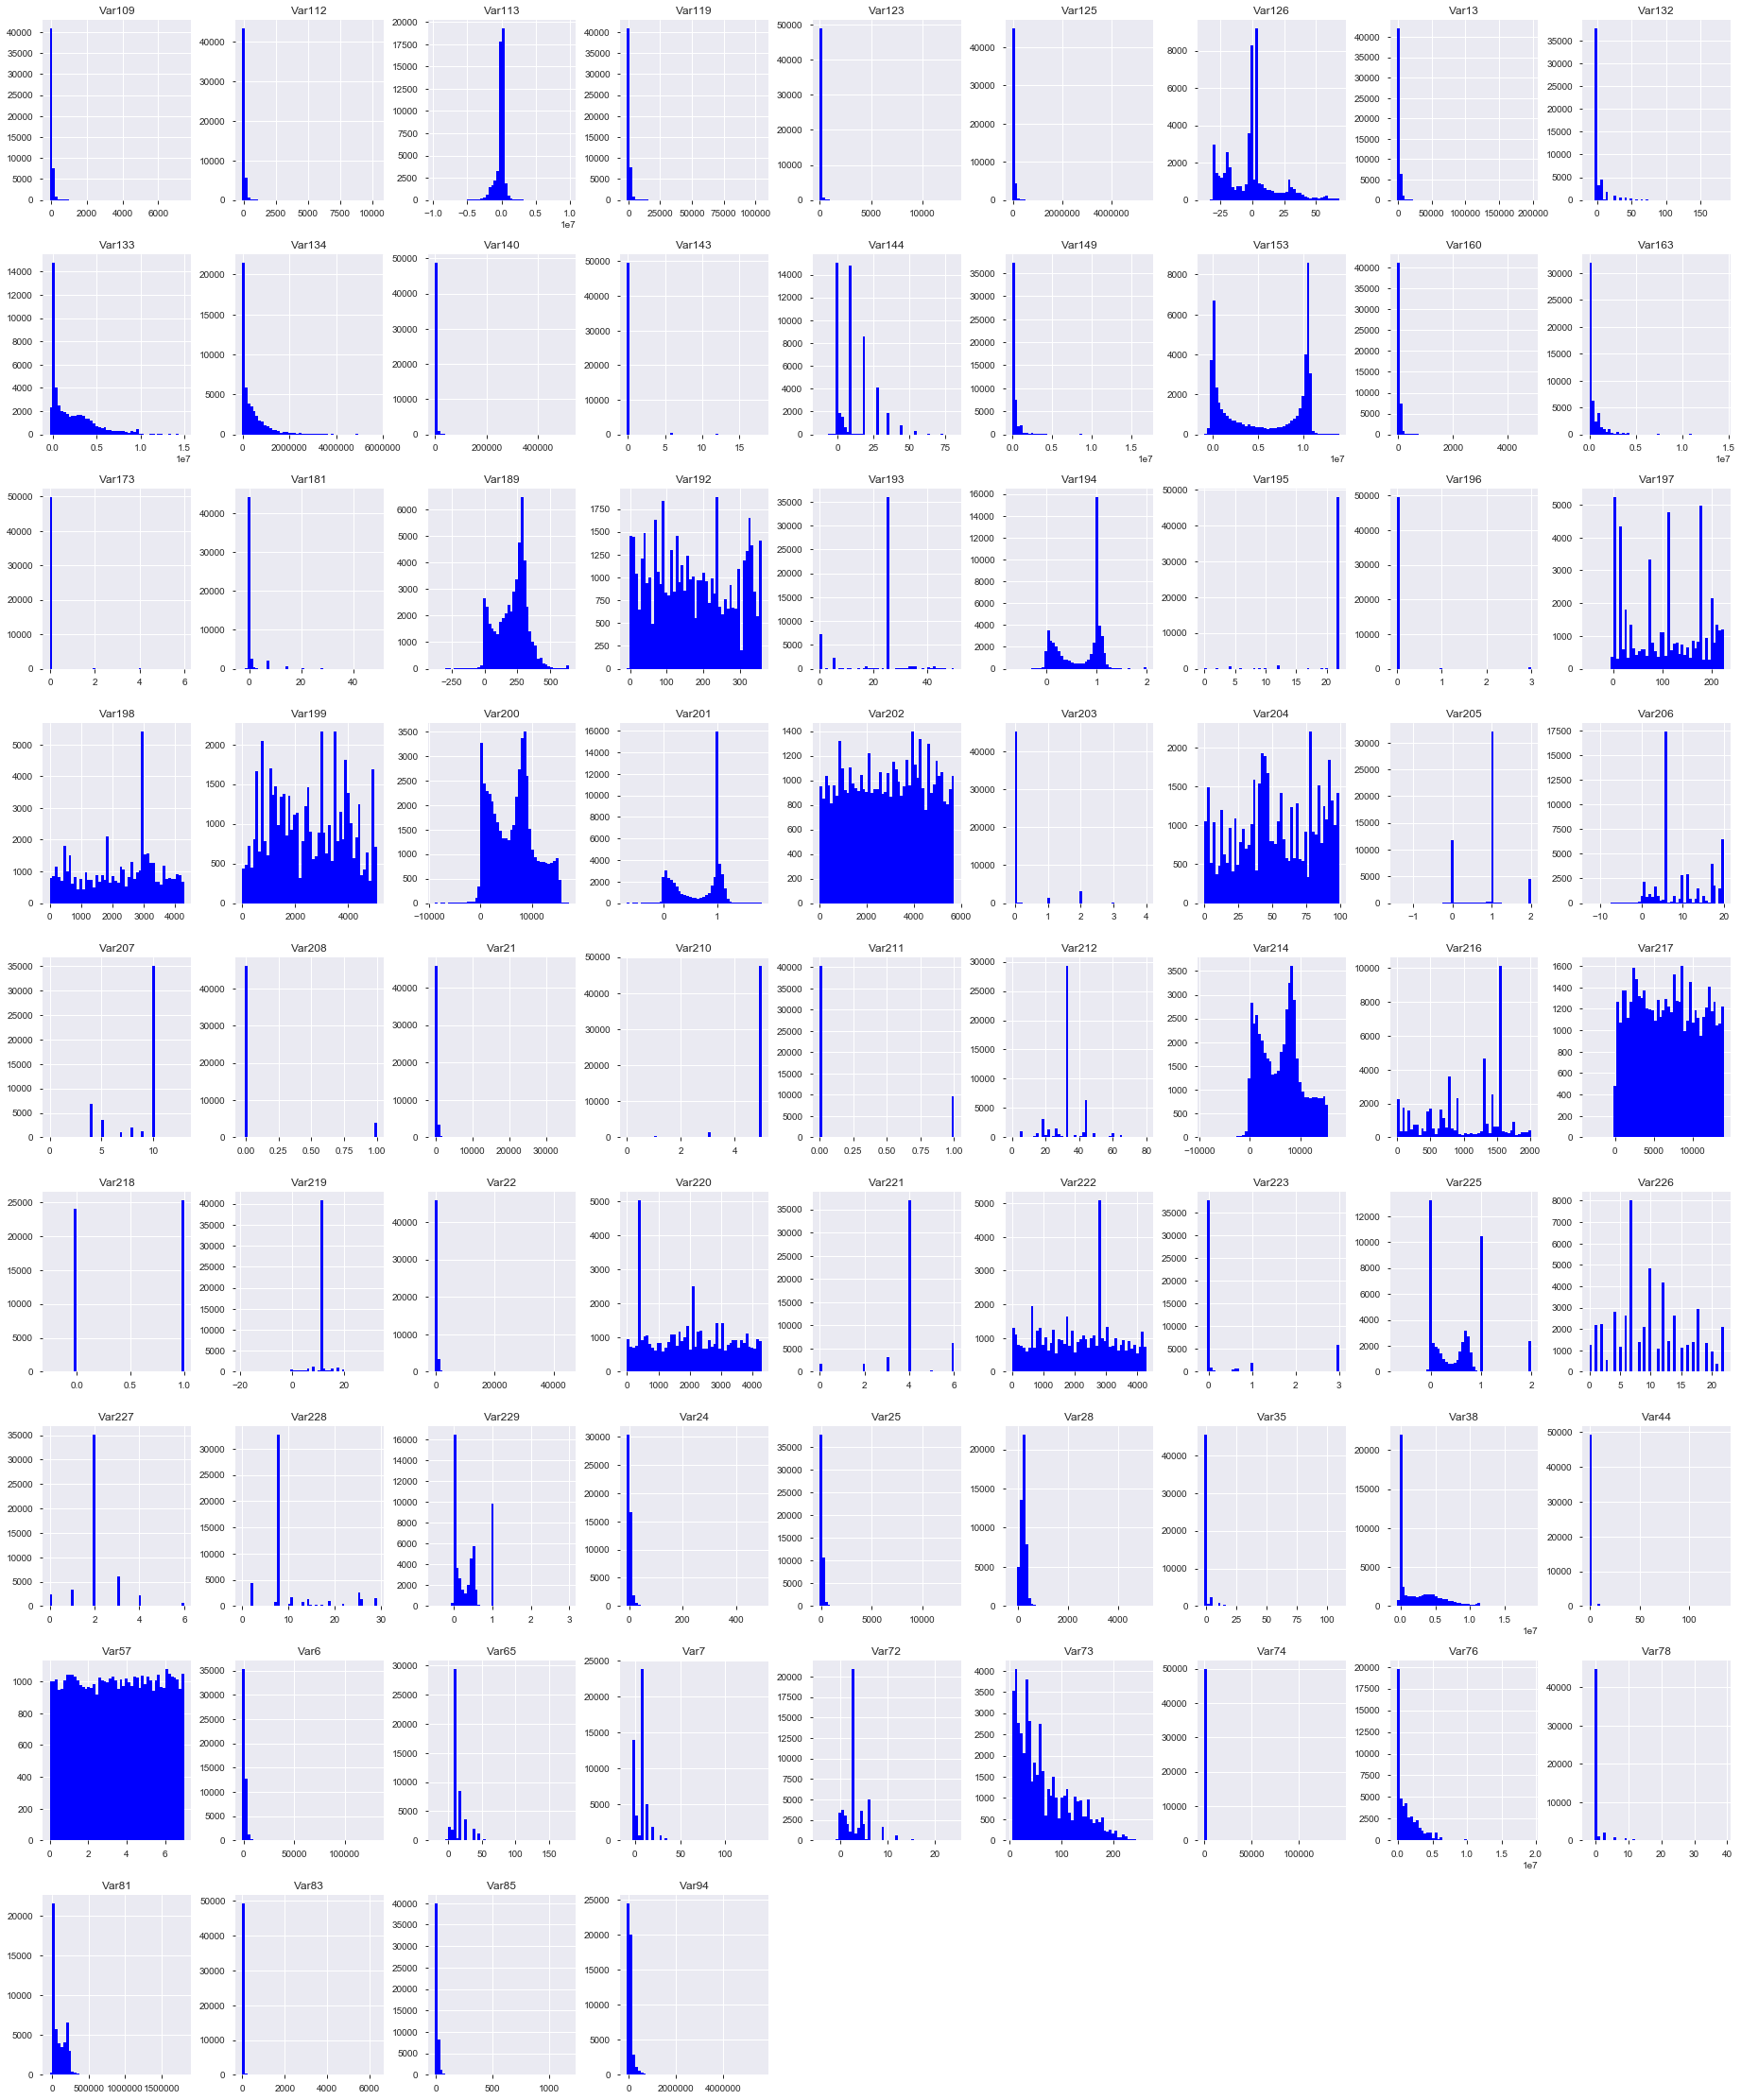

In [39]:
#Check the distribution of all the independent variables
df_train_appetency.drop(['appetency'],axis=1).hist(bins=50,color='blue',figsize=(32,40))
plt.show()

#### Obsertvation:- The different columns distribution 

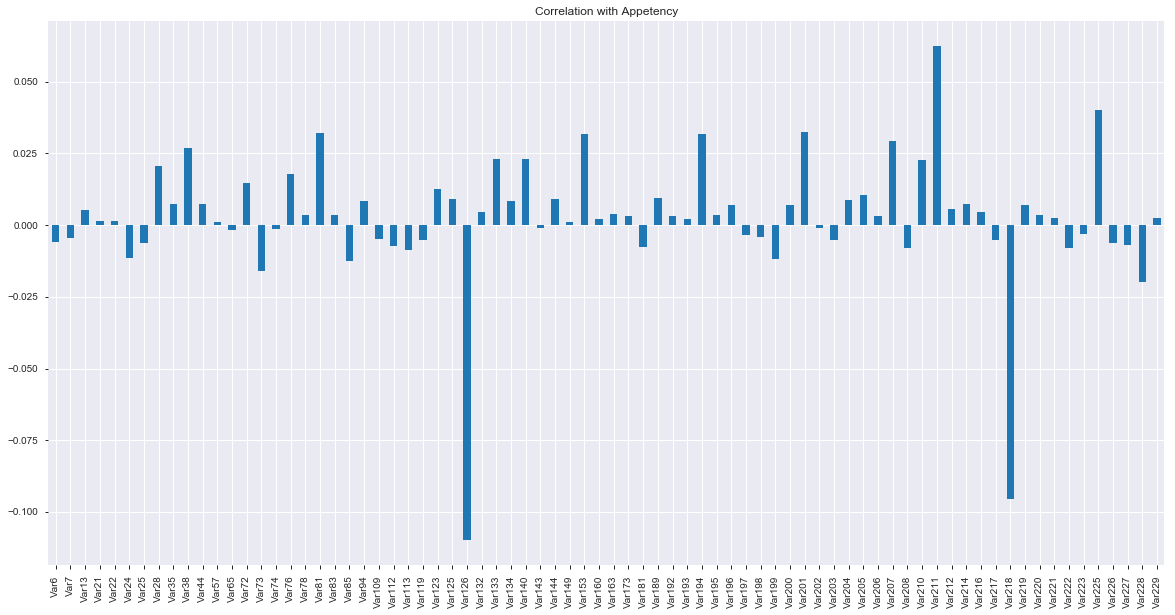

In [40]:
dataset1 = df_train_appetency.drop(columns = ['appetency'])
dataset1.corrwith(df_train_appetency.appetency).plot.bar(
        figsize = (20, 10), title = "Correlation with Appetency", fontsize = 10,
        rot = 90, grid = True)

#### Observation:-The above chart shows correlation between appetency and the different independent variables.

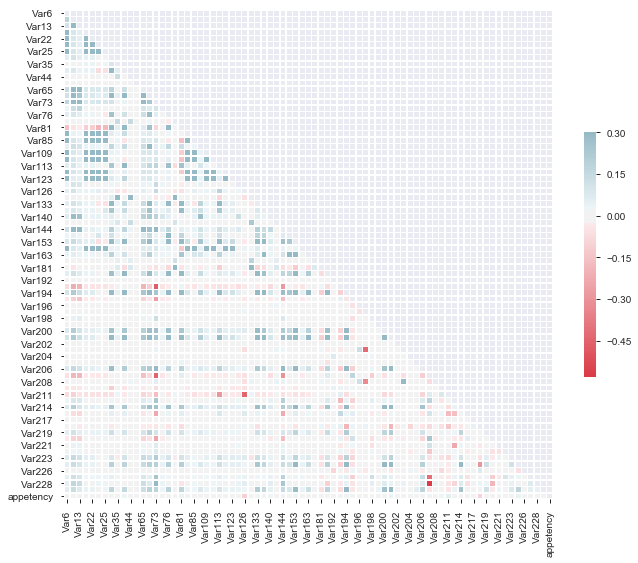

In [41]:
halfHeatMap(df_train_appetency,False)

##### Churn

In [42]:
df_train_churn['churn'].describe()

count    50000.00000
mean         0.07344
std          0.26086
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max          1.00000
Name: churn, dtype: float64

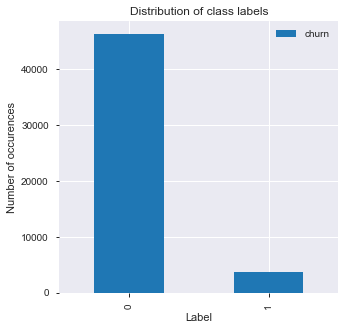

In [43]:
#Check the class distribution in the given data
df_train_churn['churn'].value_counts().plot(figsize=(5,5),kind='bar',legend='True')
plt.title("Distribution of class labels")
plt.xlabel("Label")
plt.ylabel("Number of occurences")
plt.show()

In [44]:
#Get percentage  information
not_churn=df_train_churn[df_train_churn['churn']==0].shape[0]
churn=df_train_churn[df_train_churn['churn']==1].shape[0]
total=not_churn+churn

print("Percentage of Not appetency: {}".format(np.round(100*churn/total,4)))
print("Percentage of appetency: {}".format(np.round(100*not_churn/total,4)))

Percentage of Not appetency: 7.344
Percentage of appetency: 92.656


In [45]:
df_train_churn.shape

(50000, 77)

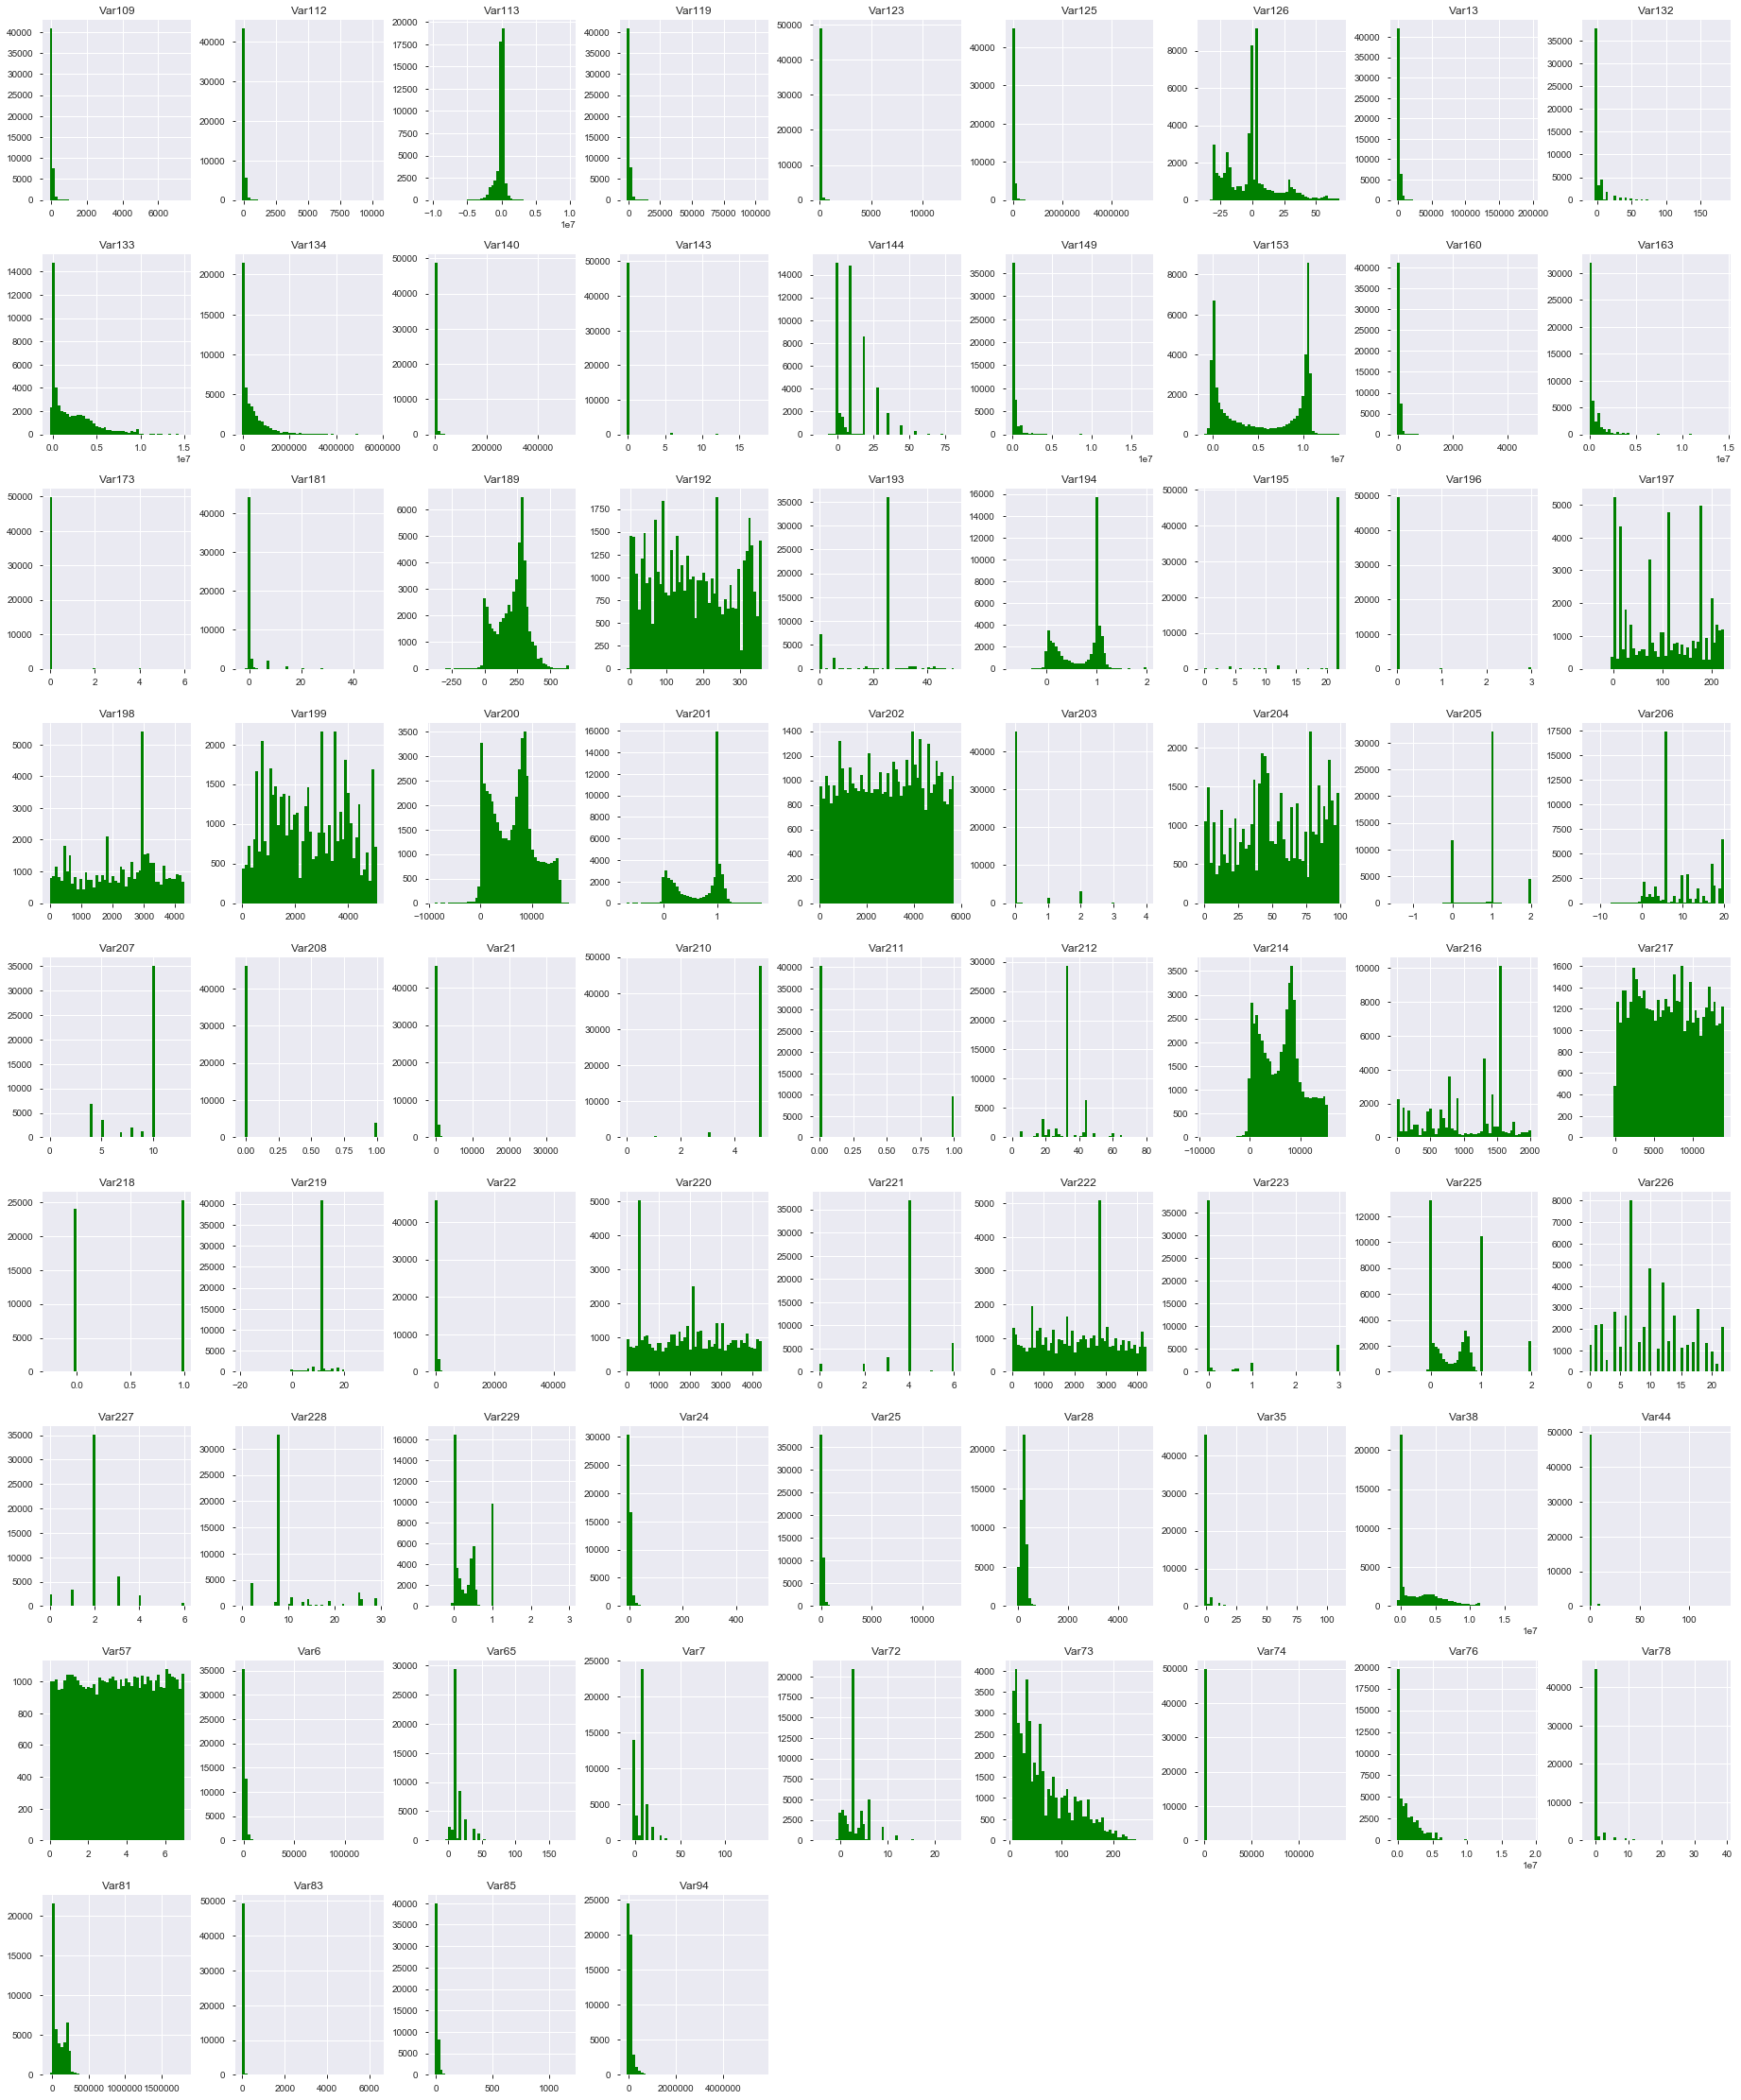

In [46]:
#Check the distribution of all the independent variables
df_train_churn.drop(['churn'],axis=1).hist(bins=50,color='green',figsize=(32,40))
plt.show()

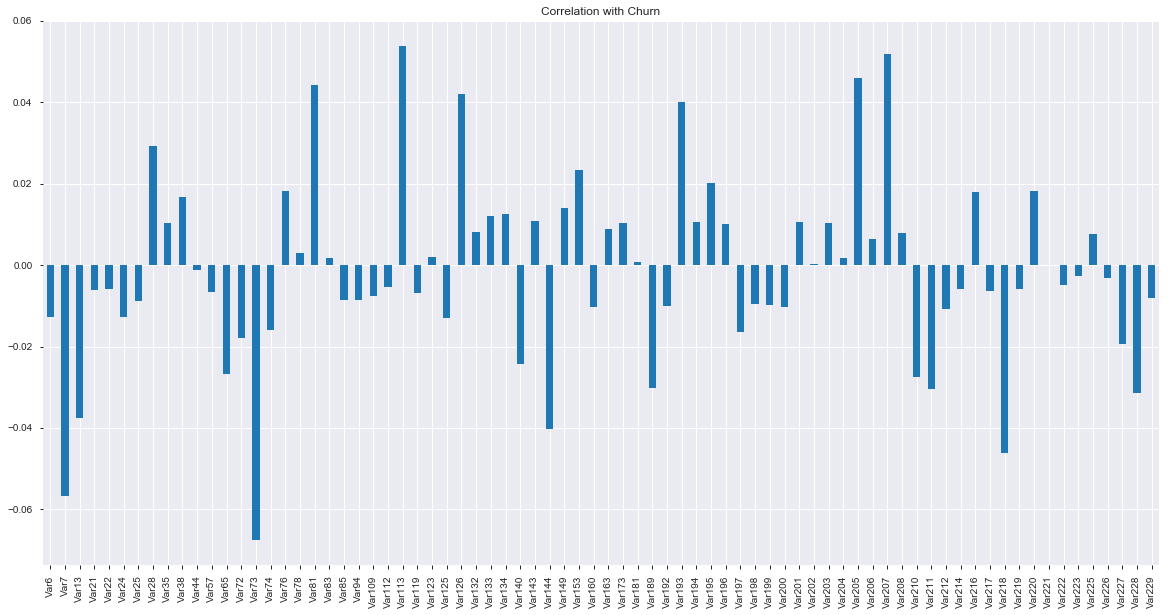

In [47]:
dataset2 = df_train_churn.drop(columns = ['churn'])
dataset2.corrwith(df_train_churn.churn).plot.bar(
        figsize = (20, 10), title = "Correlation with Churn", fontsize = 10,
        rot = 90, grid = True)

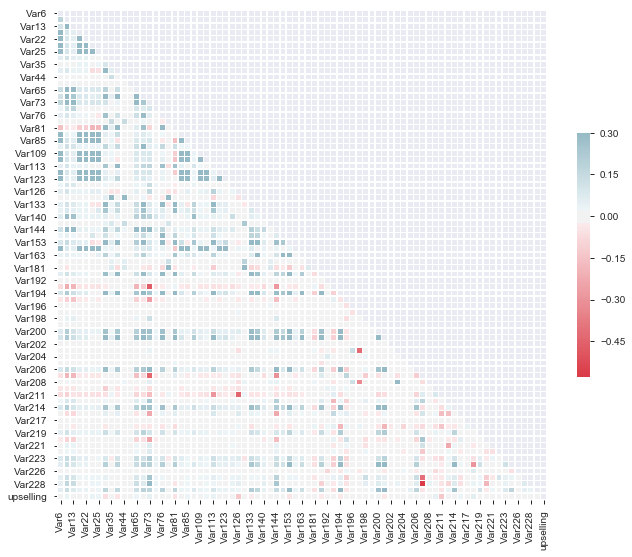

In [48]:
halfHeatMap(df_train_upselling,False)

##### Upselling

In [49]:
df_train_upselling['upselling'].describe()

count    50000.000000
mean         0.073640
std          0.261187
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: upselling, dtype: float64

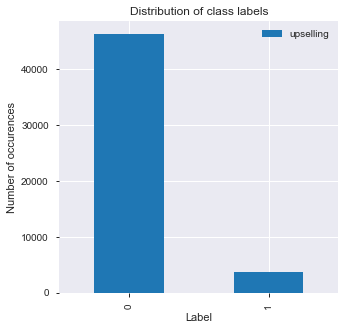

In [50]:
df_train_upselling['upselling'].value_counts().plot(figsize=(5,5),kind='bar',legend='True')
plt.title("Distribution of class labels")
plt.xlabel("Label")
plt.ylabel("Number of occurences")
plt.show()

In [51]:
#Get percentage  information
not_upselling=df_train_upselling[df_train_upselling['upselling']==0].shape[0]
upselling=df_train_upselling[df_train_upselling['upselling']==1].shape[0]
total=not_upselling+upselling

print("Percentage of Not appetency: {}".format(np.round(100*upselling/total,4)))
print("Percentage of appetency: {}".format(np.round(100*not_upselling/total,4)))

Percentage of Not appetency: 7.364
Percentage of appetency: 92.636


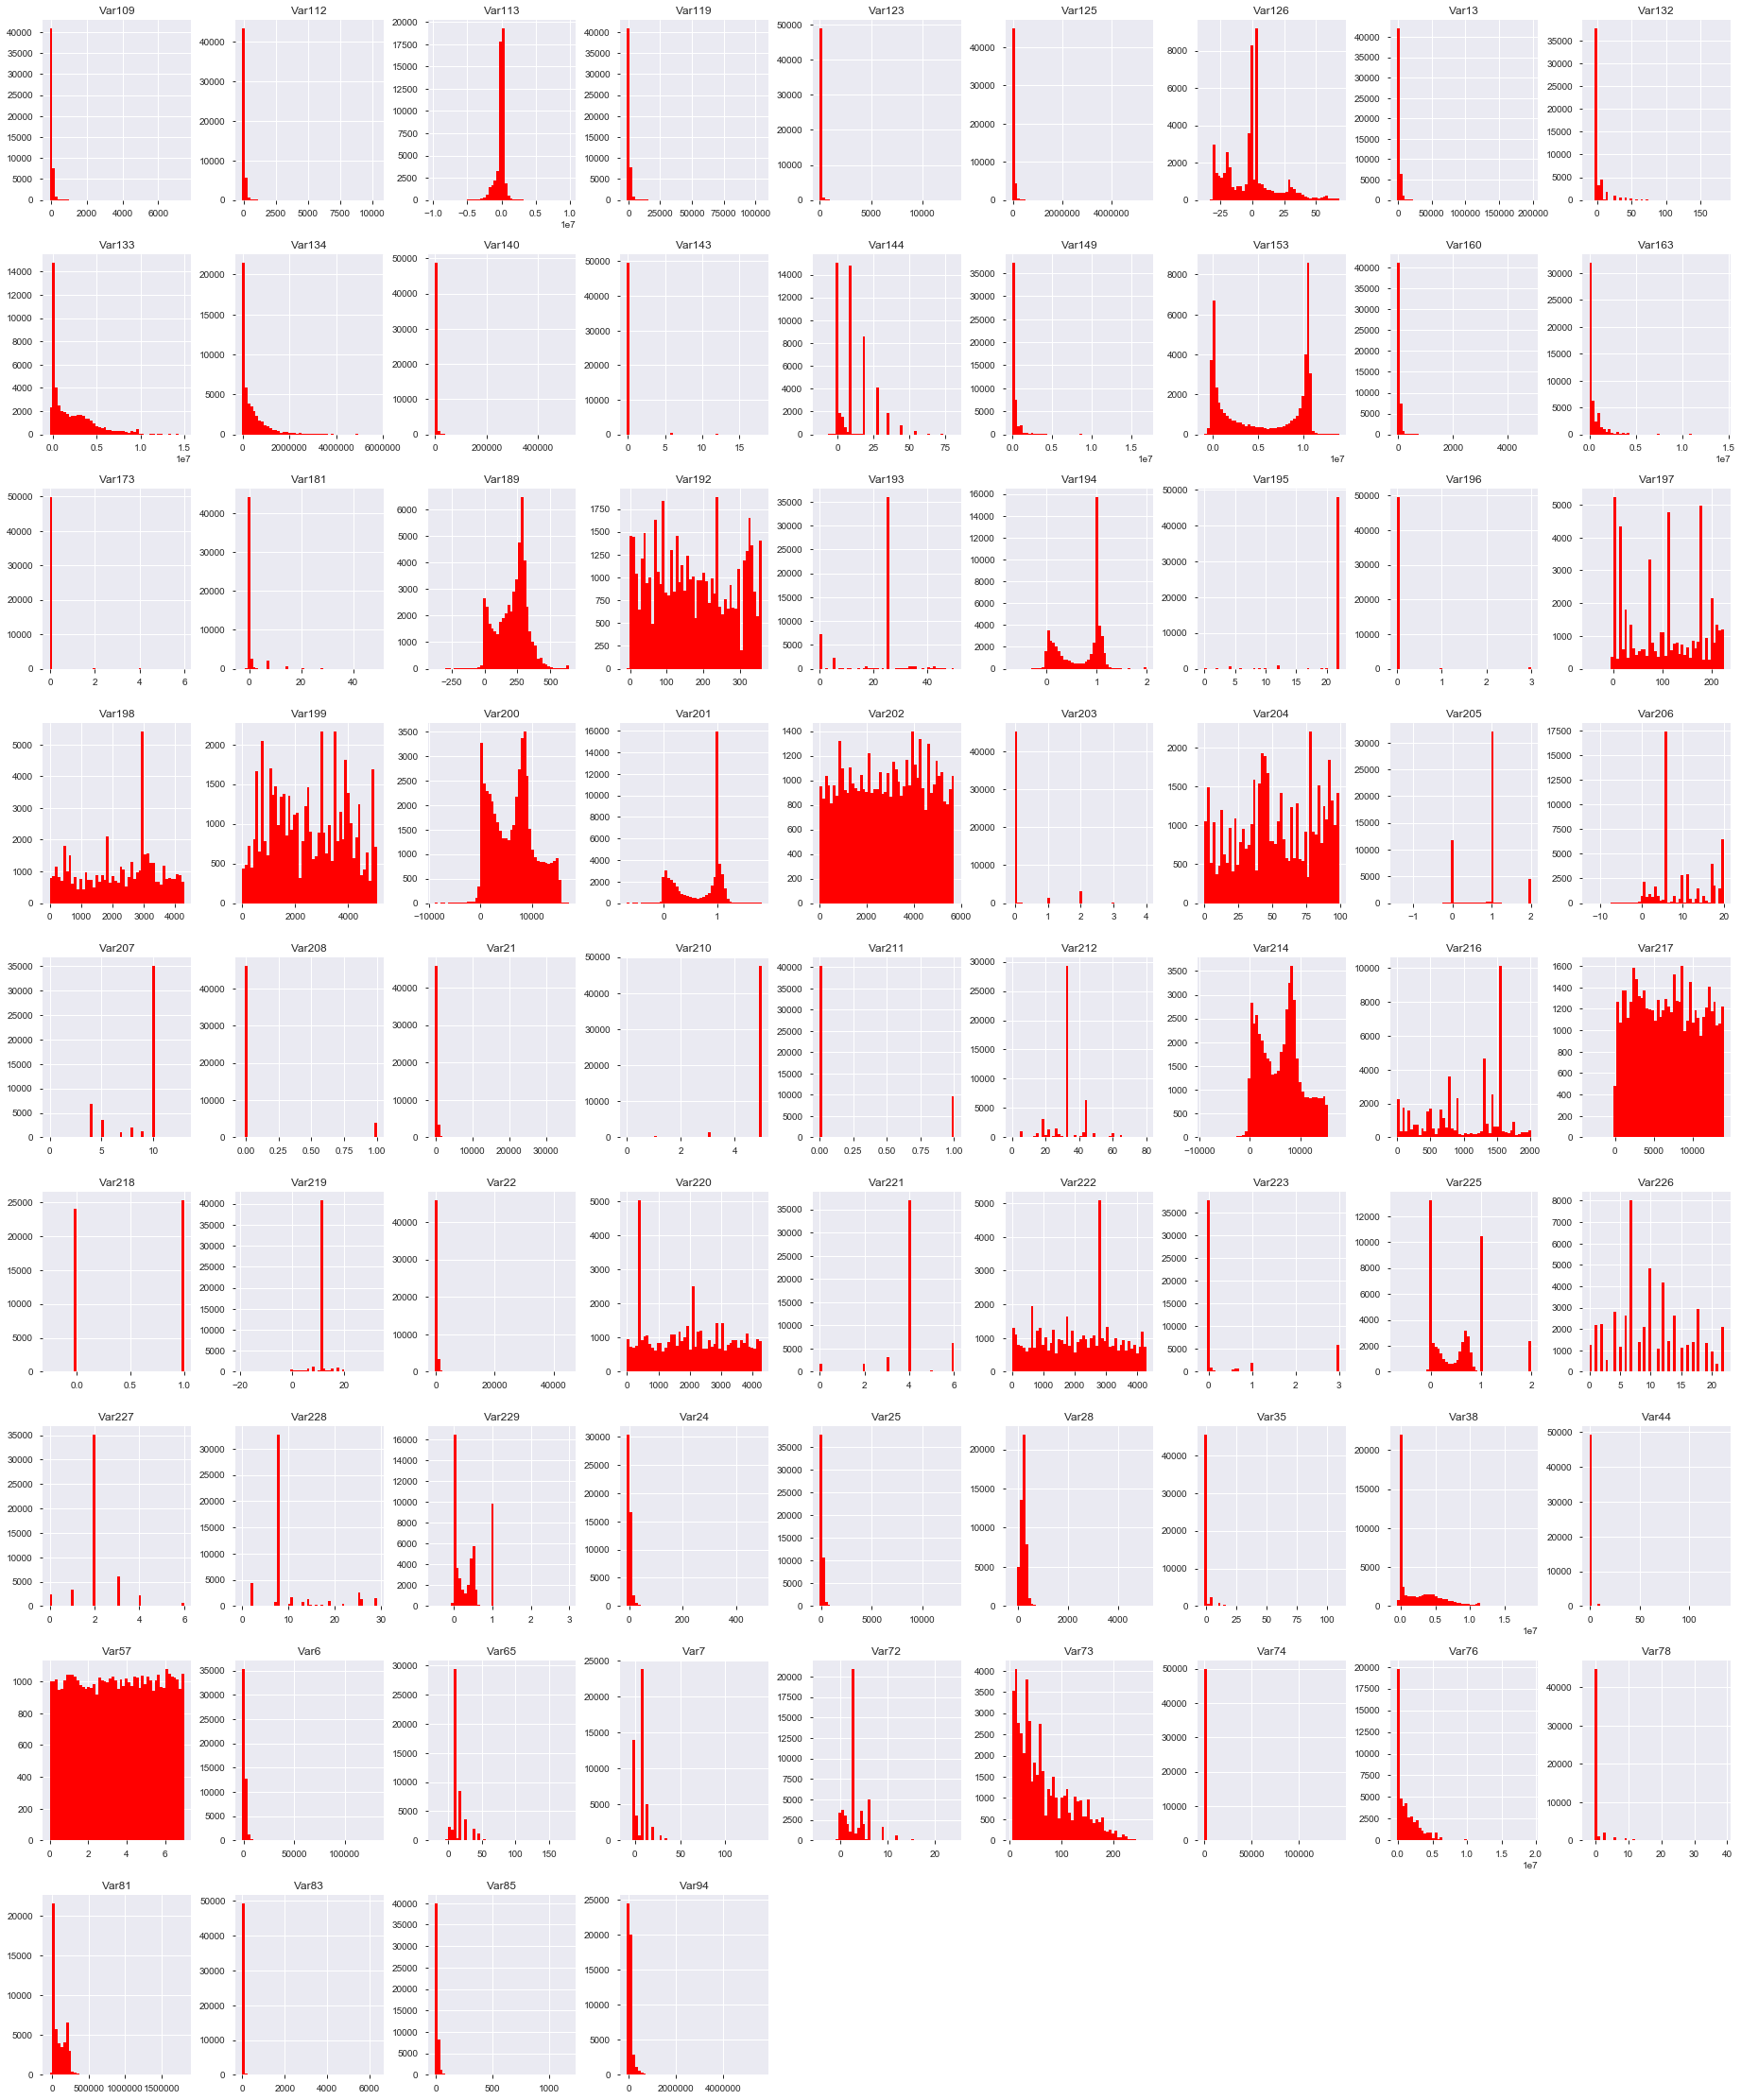

In [52]:
#Check the distribution of all the independent variables
df_train_upselling.drop(['upselling'],axis=1).hist(bins=50,color='red',figsize=(32,40))
plt.show()

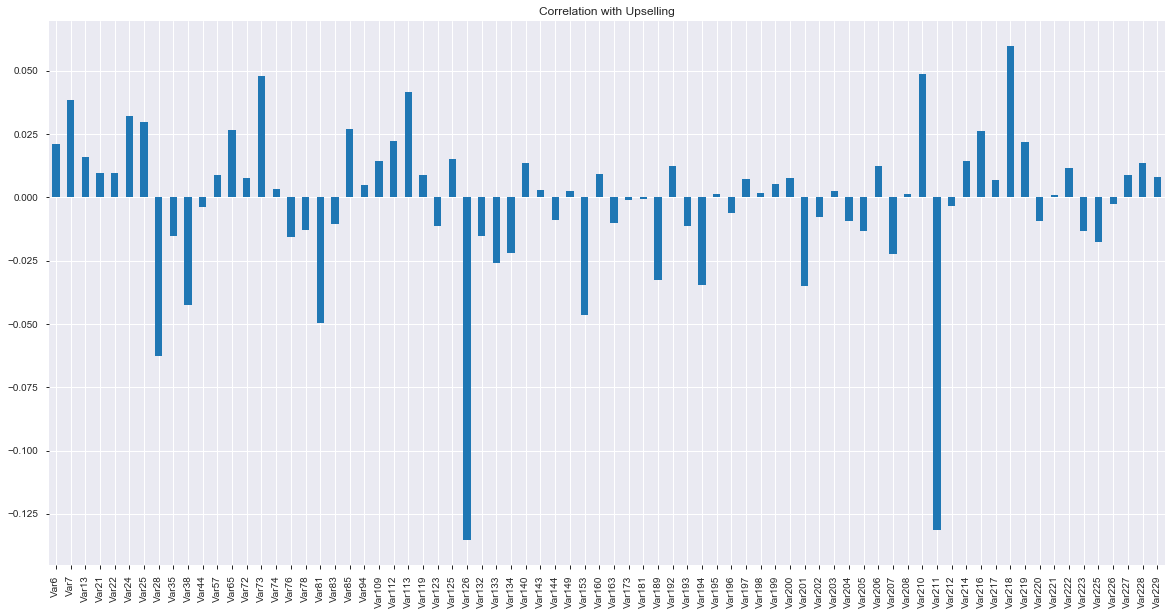

In [53]:
dataset3 = df_train_upselling.drop(columns = ['upselling'])
dataset3.corrwith(df_train_upselling.upselling).plot.bar(
        figsize = (20, 10), title = "Correlation with Upselling", fontsize = 10,
        rot = 90, grid = True)

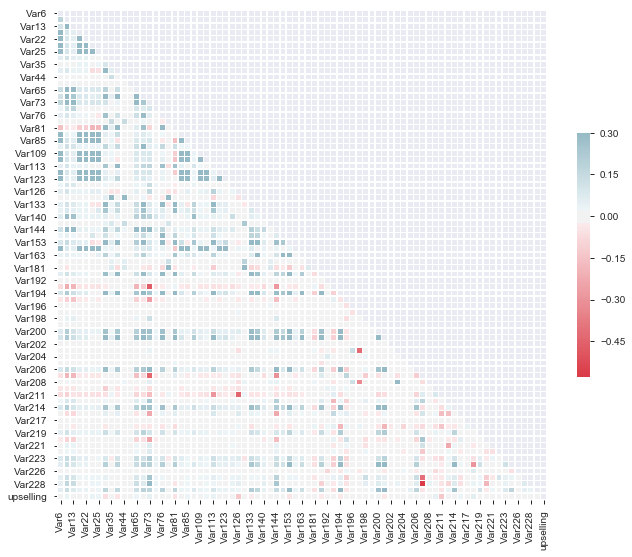

In [54]:
halfHeatMap(df_train_upselling,False)